In [1]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()

In [2]:
adata_hpc=sc.read('data/liver_hpc_anno.h5ad',compression='gzip')

In [3]:
adata_hpc.X.max()

8615.0

In [4]:
import numpy as np
import pandas as pd
bulk=pd.read_csv('data/GSE58827_FPKM.txt.gz',index_col=0,sep='\t',header=1)
#bulk=ov.bulk.Matrix_ID_mapping(bulk,'genesets/pair_GRCm39.tsv')
bulk.head()

,D-2,D-2.1,D-2.2,D0,D0,D0.1,D1,D1.1,D1.2,D3,...,D25.2,D30,D30.1,D30.2,D45,D45.1,D45.2,D60,D60.1,D60.2
Gene Symbol,,,,,,,,,,,,,,,,,,,,,
0610007C21Rik,18.48160,28.29490,24.61790,42.37870,33.34830,41.60700,57.6597,63.41470,64.04740,37.80720,...,51.30120,63.78840,45.19360,54.98550,45.92580,48.11880,56.38370,50.75280,48.55550,54.92510
0610007L01Rik,14.19070,12.70240,11.80150,12.56880,8.31761,9.62451,16.7531,13.15530,13.00190,12.49530,...,7.70820,6.89976,10.68430,11.19820,7.71271,7.78097,6.92665,8.95075,8.89625,7.78528
0610007P08Rik,1.71090,0.83838,0.76108,0.36203,0.50162,0.39988,1.0015,0.64103,0.59142,1.03540,...,0.37039,0.17313,0.62976,0.34409,0.34740,0.27636,0.23581,0.56421,0.71718,0.46741
0610007P14Rik,41.85590,48.17630,45.65490,15.94520,41.84570,49.94160,32.0791,41.87910,30.60340,51.52930,...,49.23110,28.13490,35.72540,44.27430,32.64790,43.05270,31.75820,33.15400,42.72720,49.06030
0610007P22Rik,6.69505,9.71821,8.49785,9.61188,6.70561,7.89604,8.6380,10.05780,11.05510,6.81731,...,6.45745,8.29360,8.04557,7.57137,5.29742,6.44480,7.82238,5.25578,6.53128,7.03206


In [5]:
#raw_columns=bulk.columns.tolist()
#new_columns=[i+'-'+j for i, j in zip(bulk.iloc[0],raw_columns)]

In [5]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata_hpc,
                                    bulk_group=bulk.columns.tolist(),
                                    celltype_key='celltype',)
#bulktb.bulk_preprocess_lazy()
#bulktb.single_preprocess_lazy()

In [6]:
bulktb.vae_configure(cell_target_num=200)

......random select 5000 single cells
......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [25]:
bulktb.vae_train(batch_size=256,
    learning_rate=1e-4,
    hidden_size=256,
    epoch_num=3500,
    vae_save_dir='model',
    vae_save_name='hpc_vae',
    generate_save_dir='output',
    generate_save_name='hpc')

#bulktb.vae_load('model/dgd_vae.pth')

...begin vae training


Train Epoch: 2551:  73%|███████▎  | 2552/3500 [20:43<07:41,  2.05it/s, loss=1.1536, min_loss=1.1536]

Early stopping at epoch 2553...
min loss = 1.1536177322268486
...vae training done!


...save trained vae in model/hpc_vae.pth.


In [8]:
bulktb.vae_load('model/hpc_vae.pth')

loading model from model/hpc_vae.pth
loading model from model/hpc_vae.pth


In [9]:
test_adata=bulktb.vae_generate(leiden_size=25)

...generating


generating: 100%|██████████| 3600/3600 [00:00<00:00, 6438.35it/s]

generated done!
extracting highly variable genes


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=100
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 37 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
The filter leiden is  ['27', '28', '29', '30', '31', '32', '33', '34', '35', '36']


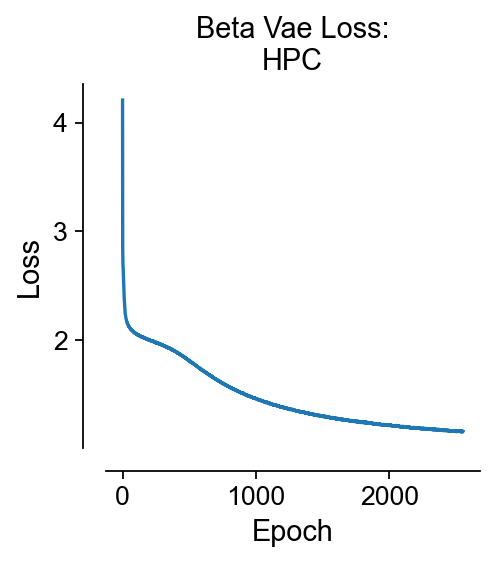

In [26]:
import matplotlib.pyplot as plt
fig,ax=bulktb.vae_model.plot_loss(figsize=(3,3))

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Beta Vae Loss:\nHPC',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_vae_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_vae_hpc.pdf',dpi=300,bbox_inches='tight')


<AxesSubplot: title={'center': 'The number of cells per cell type in bulk-seq data'}, xlabel='Cell type', ylabel='Cell number'>

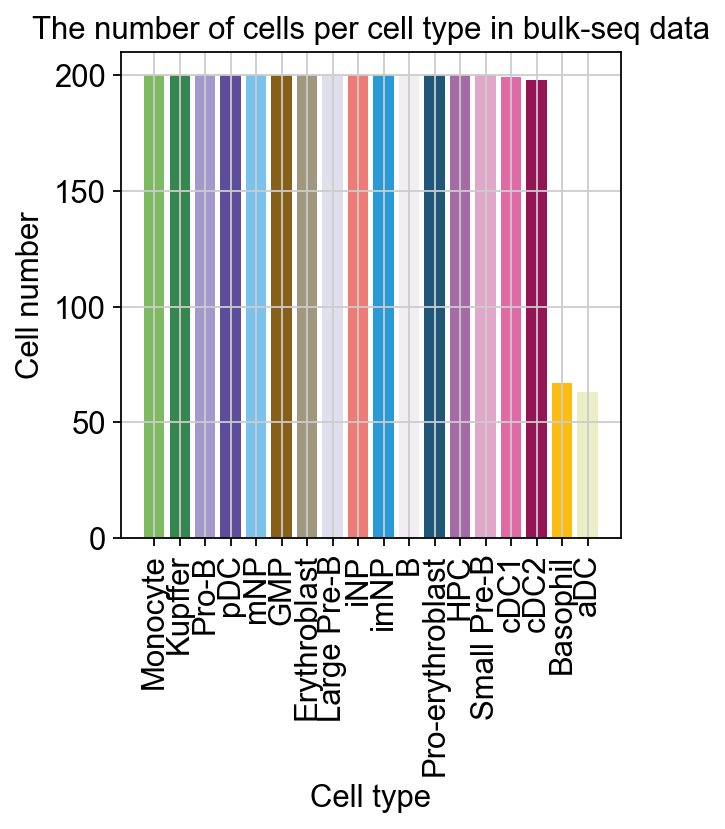

In [11]:
ov.bulk2single.bulk2single_plot_cellprop(test_adata,
                                         celltype_key='celltype',
                                        )

In [12]:
adata_hpc.uns['log1p']['base']=None

In [13]:
cor_pd=ov.bulk2single.bulk2single_plot_correlation(adata_hpc,test_adata,celltype_key='celltype',
                                           return_table=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


In [14]:
#sc.tl.rank_genes_groups(single_data, celltype_key, method='wilcoxon')
marker_df = pd.DataFrame(adata_hpc.uns['rank_genes_groups']['names']).head(200)
#marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(generate_adata.var.index.tolist()))
marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(test_adata.var.index.tolist()))

# the mean expression of 200 marker genes of input sc data
sc_marker = adata_hpc[:,marker].to_df()
sc_marker['celltype'] = adata_hpc.obs['celltype']
sc_marker_mean = sc_marker.groupby('celltype')[marker].mean()

In [15]:
sc_marker_mean=sc_marker_mean.T

In [16]:
rf_ct = list(sc_marker_mean.columns)

In [17]:
cor_pd=pd.DataFrame(cor_pd,
                   index=rf_ct,
                   columns=rf_ct)

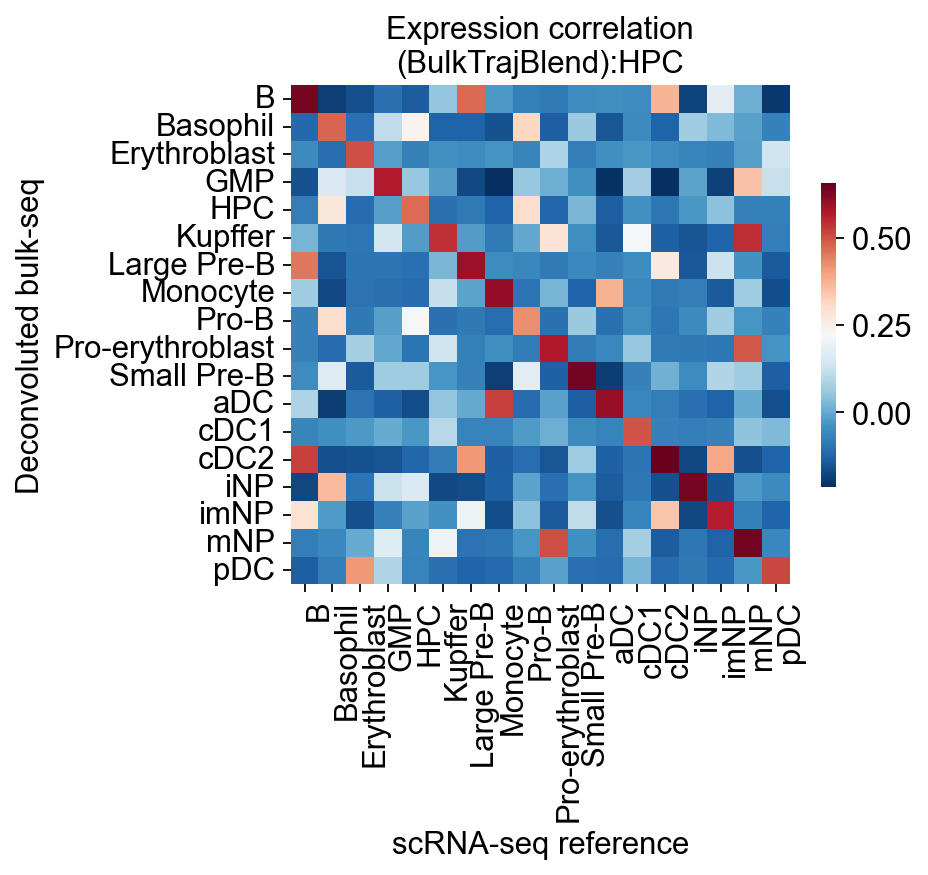

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cor_pd,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Expression correlation\n(BulkTrajBlend):HPC")
plt.savefig('figures/heatmap_expcor_btb_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_expcor_btb_hpc.pdf',dpi=300,bbox_inches='tight')


In [12]:
cmk1=ov.single.get_celltype_marker(test_adata,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


In [13]:
adata_hpc1=ov.pp.preprocess(adata_hpc,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 18578/18648 genes are kept. Among 18578 genes, 17425 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Igha', 'Gm26917', 'Malat1', 'S100a8', 'S100a9', 'Igkc', 'Hbb-bs', 'Camp']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [14]:
cmk2=ov.single.get_celltype_marker(adata_hpc1,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)


In [15]:
cmk1={}
for clt in test_adata.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(test_adata, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk1[clt]=degs['names'][:100].tolist()

In [16]:
cmk2={}
for clt in adata_hpc1.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(adata_hpc1, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk2[clt]=degs['names'][:100].tolist()

In [17]:
all_gene=[]
for clt in cmk1.keys():
    all_gene+=cmk1[clt]
for clt in cmk2.keys():
    all_gene+=cmk2[clt]
all_gene=list(set(all_gene))

In [18]:
cmk1_pd=pd.DataFrame(index=all_gene)
for clt in cmk1.keys():
    cmk1_pd[clt]=0
    cmk1_pd.loc[cmk1[clt],clt]=1
cmk2_pd=pd.DataFrame(index=all_gene)
for clt in cmk2.keys():
    cmk2_pd[clt]=0
    cmk2_pd.loc[cmk2[clt],clt]=1

In [19]:
cmk1_pd['B'].sum()

62

In [20]:
cmk2_pd['B'].sum()

100

In [21]:
from scipy import spatial
plot_data=pd.DataFrame(index=test_adata.obs['celltype'].cat.categories,
                      columns=test_adata.obs['celltype'].cat.categories)
for clt1 in cmk1.keys():
    for clt2 in cmk1.keys():
    #print(clt,1 - spatial.distance.cosine(cmk1_pd['B'], cmk2_pd[clt]))
        plot_data.loc[clt1,clt2]=1 - spatial.distance.cosine(cmk1_pd[clt1], cmk2_pd[clt2])

In [22]:
plot_data=plot_data.astype(float)

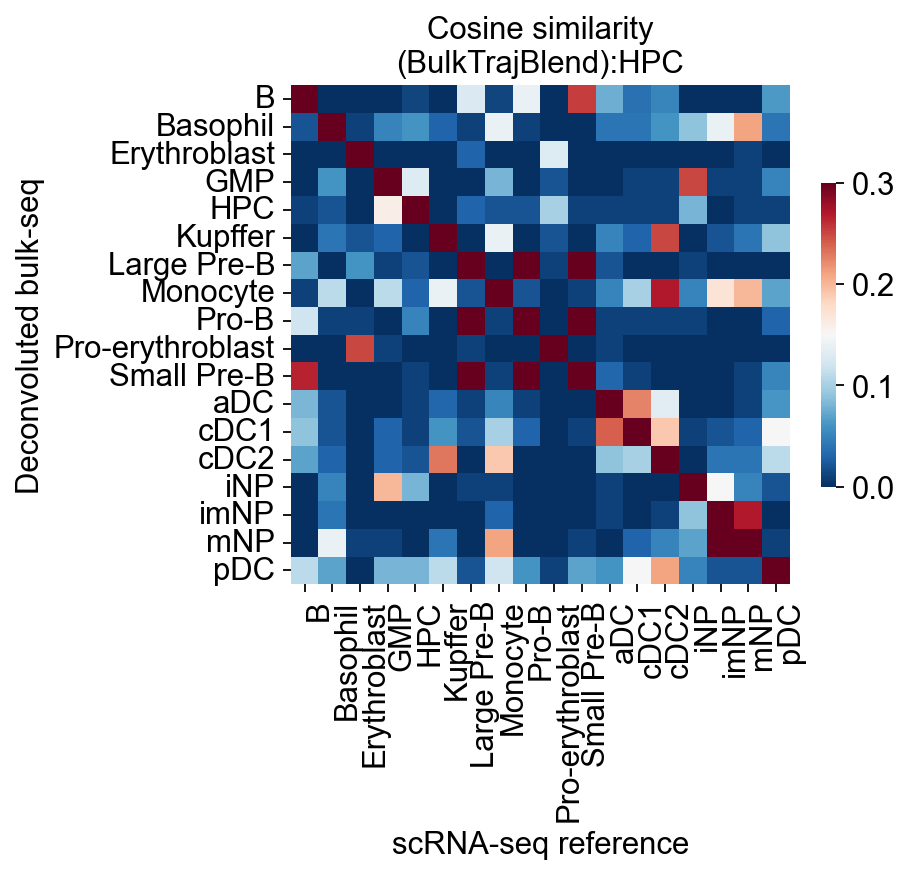

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
import seaborn as sns
sns.heatmap(plot_data,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,vmax=0.3)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Cosine similarity\n(BulkTrajBlend):HPC")
plt.savefig('figures/heatmap_cossim_btb_hpc.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_cossim_btb_hpc.pdf',dpi=300,bbox_inches='tight')


In [43]:
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)

# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

print("对角线均值:", diagonal_mean)
print("非对角线均值:", non_diagonal_mean)

对角线均值: 0.5631987742145932
非对角线均值: -0.023593777334333103


In [45]:
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

print("对角线均值:", diagonal_mean)
print("非对角线均值:", non_diagonal_mean)

对角线均值: 0.6440443313050281
非对角线均值: 0.04967595132995179


In [53]:
adata3=test_adata[test_adata.obs['celltype']=='Basophil']
adata3

View of AnnData object with n_obs × n_vars = 67 × 1714
    obs: 'celltype', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'leiden', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [54]:
import anndata
adata1=anndata.concat([bulktb.vae_model.single_data,adata3],
                     merge='same')
adata1

AnnData object with n_obs × n_vars = 5067 × 1714
    obs: 'celltype'

In [48]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [55]:
ov.pp.scale(adata1)
ov.pp.pca(adata1,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [56]:
adata1.obsm["X_mde"] = ov.utils.mde(adata1.obsm["scaled|original|X_pca"])
adata1

AnnData object with n_obs × n_vars = 5067 × 1714
    obs: 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

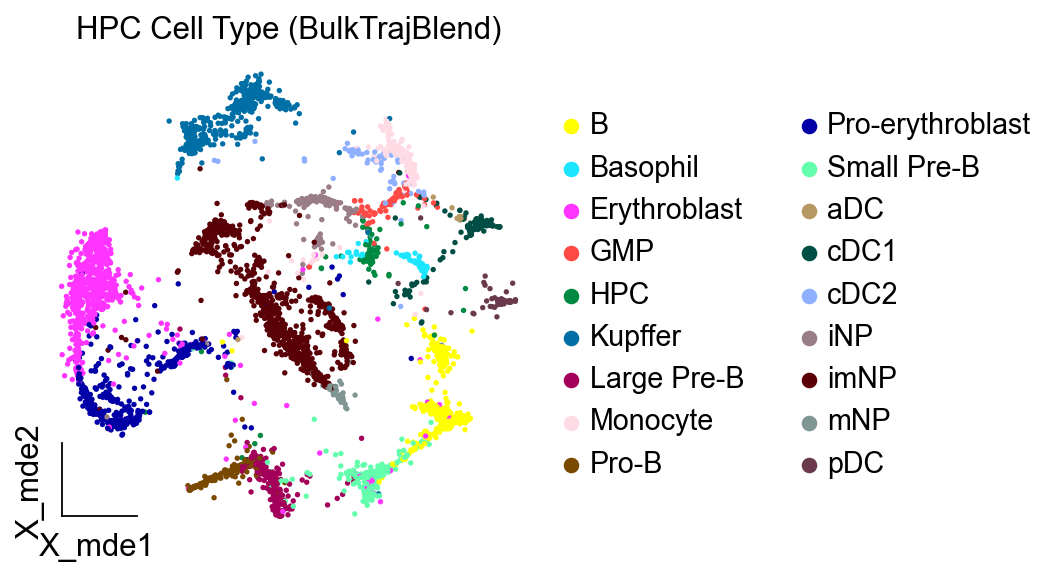

In [57]:
ov.utils.embedding(adata1,
                basis='X_mde',
           color=['celltype'],title='HPC Cell Type (BulkTrajBlend)',
                   frameon='small',show=False,
           wspace=0.4,palette=sc.pl.palettes.default_102)
plt.savefig('figures/umap_hpc_btb.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/umap_hpc_btb.pdf',dpi=300,bbox_inches='tight')


In [7]:
adata2=bulktb.vae_model.single_data.copy()

In [8]:
adata2.raw = adata2
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata2 = adata2[:, adata2.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
ov.pp.scale(adata2)
ov.pp.pca(adata2,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [10]:
adata2.obsm["X_mde"] = ov.utils.mde(adata2.obsm["scaled|original|X_pca"])
adata2

AnnData object with n_obs × n_vars = 5000 × 3575
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'lib_ID', 'lib', 'percent.mt', 'timepoint', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'timepoint_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_mde', 'X_mde_hpc', 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'connectivities', 'distances'

In [14]:
adata2.uns['scaled|original|pca_var_ratios']

array([0.03828995, 0.02203958, 0.02010177, 0.00981365, 0.00765554,
       0.00663802, 0.0060489 , 0.00546947, 0.00491379, 0.00448196,
       0.00392125, 0.00360923, 0.00308134, 0.00280451, 0.00270297,
       0.00258297, 0.00222222, 0.00196814, 0.00181953, 0.00180166,
       0.0016758 , 0.00156872, 0.00145701, 0.00140349, 0.00137118,
       0.00133003, 0.00132554, 0.00129611, 0.00127141, 0.0012159 ,
       0.00115621, 0.00115   , 0.00111434, 0.00109806, 0.00107792,
       0.00107288, 0.00105312, 0.00104424, 0.0010417 , 0.00102835,
       0.0010232 , 0.00101685, 0.0010093 , 0.00100412, 0.00099931,
       0.00099478, 0.00098051, 0.00097637, 0.0009724 , 0.00096164],
      dtype=float32)

In [12]:
adata2.obsm['X_pca']=adata2.obsm['scaled|original|X_pca']

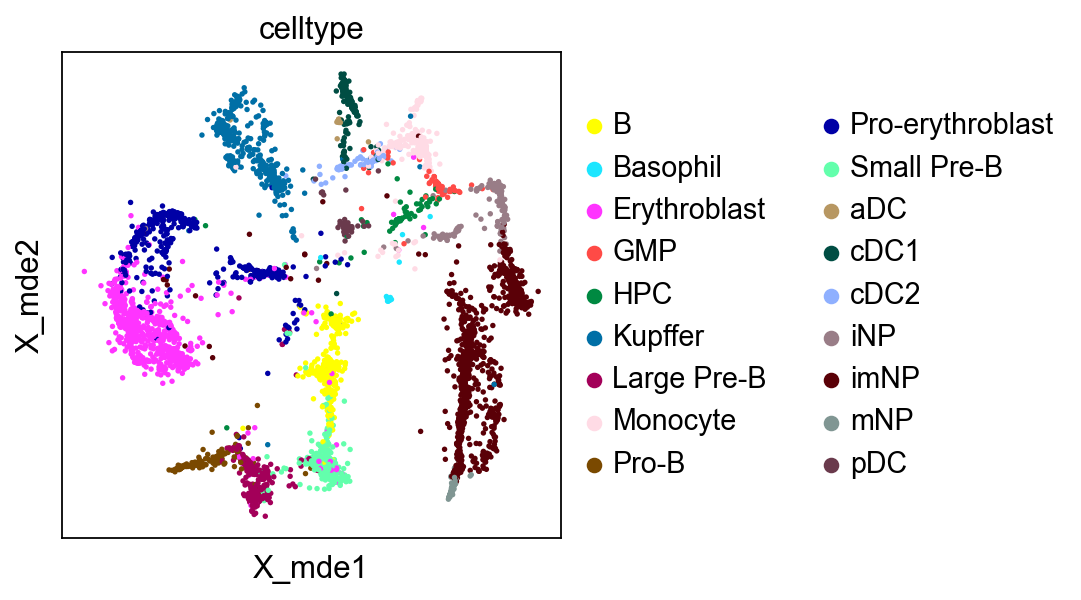

In [64]:
sc.pl.embedding(adata2,
                basis='X_mde',
           color=['celltype'],
           wspace=0.4,palette=sc.pl.palettes.default_102)

In [65]:
v0 = ov.single.pyVIA(adata=adata2,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['HPC'],
                    dataset='group')
v0.run()

2023-10-04 00:51:52.266483	Running VIA over input data of 5000 (samples) x 50 (features)
2023-10-04 00:51:52.266528	Knngraph has 15 neighbors
2023-10-04 00:51:53.799258	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 48.1 % of edges. 
2023-10-04 00:51:53.813071	Number of connected components used for clustergraph  is 1
2023-10-04 00:51:53.882640	Commencing community detection
2023-10-04 00:51:54.113333	Finished running Leiden algorithm. Found 269 clusters.
2023-10-04 00:51:54.114420	Merging 226 very small clusters (<10)
2023-10-04 00:51:54.116425	Finished detecting communities. Found 43 communities
2023-10-04 00:51:54.116650	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-04 00:51:54.122134	Graph has 1 connected components before pruning
2023-10-04 00:51:54.123925	Graph has 3 connected components after pruning
2023-10-04 00:51:54.125250	Graph has 1 connected components after reconnecting
2023-10-04 00:51:54.125655	0.0% links tri

Text(0.5, 1.0, 'Raw HPC')

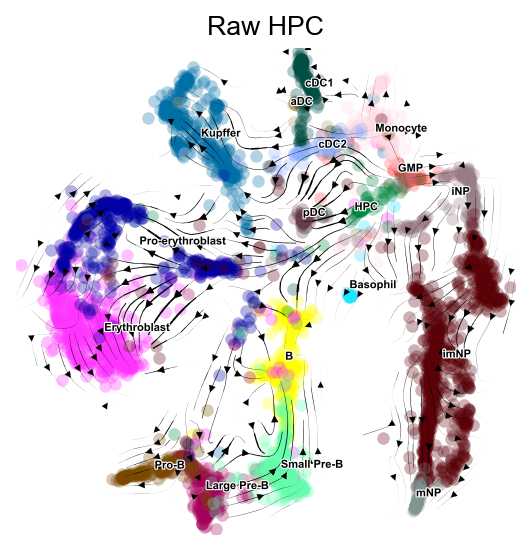

In [66]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Raw HPC',fontsize=12)

In [68]:
v0.get_pseudotime(adata2)
sc.pp.neighbors(adata2,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata2,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [69]:
raw_transitions=pd.DataFrame(adata2.uns['paga']['transitions_confidence'].toarray(),
            index=adata2.obs['celltype'].cat.categories,
            columns=adata2.obs['celltype'].cat.categories)

In [70]:
raw_transitions.loc['Basophil','HPC']

0.0

In [71]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['HPC'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

2023-10-04 00:53:09.628408	Running VIA over input data of 5067 (samples) x 50 (features)
2023-10-04 00:53:09.628449	Knngraph has 15 neighbors
2023-10-04 00:53:11.227187	Finished global pruning of 15-knn graph used for clustering at level of 0.15. Kept 48.0 % of edges. 
2023-10-04 00:53:11.241659	Number of connected components used for clustergraph  is 1
2023-10-04 00:53:11.312945	Commencing community detection
2023-10-04 00:53:11.547295	Finished running Leiden algorithm. Found 276 clusters.
2023-10-04 00:53:11.548402	Merging 236 very small clusters (<10)
2023-10-04 00:53:11.550459	Finished detecting communities. Found 40 communities
2023-10-04 00:53:11.550685	Making cluster graph. Global cluster graph pruning level: 0.15
2023-10-04 00:53:11.555895	Graph has 1 connected components before pruning
2023-10-04 00:53:11.557532	Graph has 4 connected components after pruning
2023-10-04 00:53:11.559369	Graph has 1 connected components after reconnecting
2023-10-04 00:53:11.559761	0.0% links tri

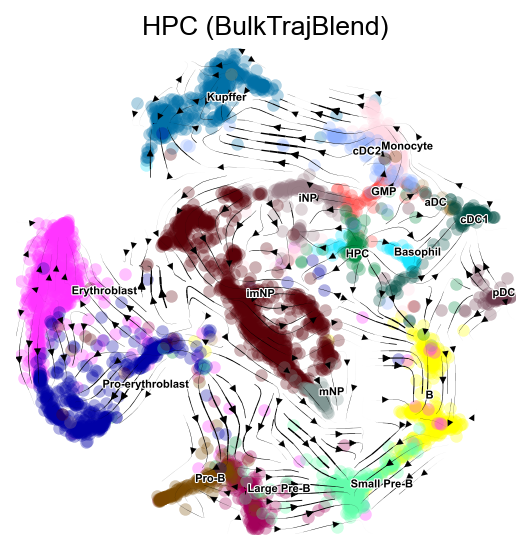

In [72]:
import matplotlib.pyplot as plt
fig,ax=v1.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('HPC (BulkTrajBlend)',fontsize=12)
plt.savefig('figures/via_hpc_btb.png',dpi=300,bbox_inches='tight')

<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

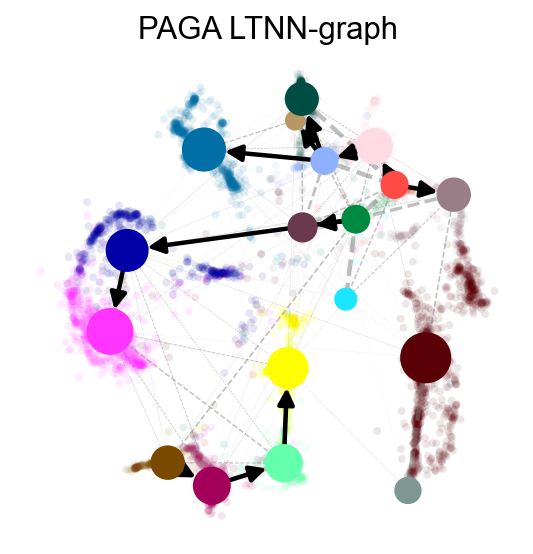

In [73]:
ov.utils.plot_paga(adata2,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

In [74]:
v1.get_pseudotime(adata1)
sc.pp.neighbors(adata1,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata1,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [75]:
after_transitions=pd.DataFrame(adata1.uns['paga']['transitions_confidence'].toarray(),
            index=adata1.obs['celltype'].cat.categories,
            columns=adata1.obs['celltype'].cat.categories)

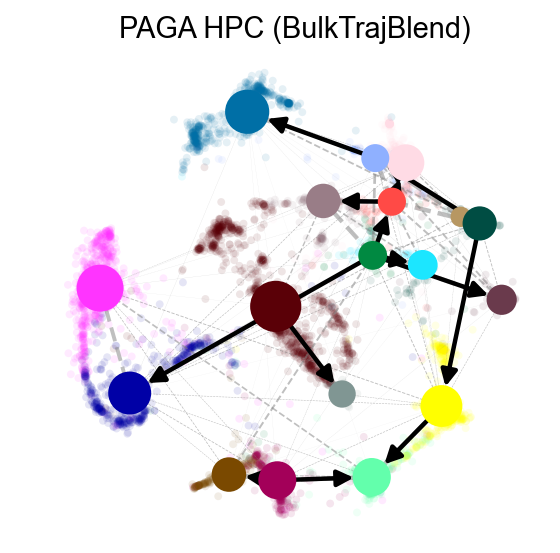

In [76]:
ov.utils.plot_paga(adata1,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA HPC (BulkTrajBlend)',fontsize=13)
plt.savefig('figures/paga_hpc_btb.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_hpc_btb.pdf',dpi=300,bbox_inches='tight')

(0.0, 1.0)

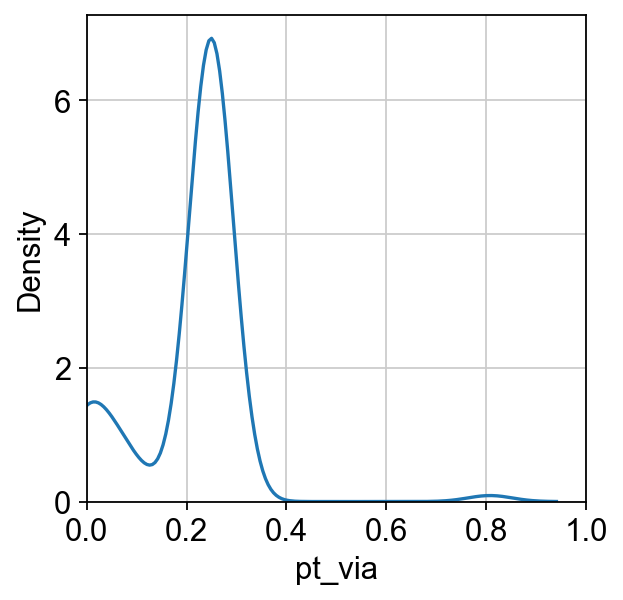

In [77]:
import seaborn as sns
sns.kdeplot(adata1.obs.loc[adata1.obs['celltype']=='Basophil'],x='pt_via')
plt.xlim(0,1)

In [78]:
np.var(adata1.obs.loc[adata1.obs['celltype']=='Basophil','pt_via'])

0.012282284923191812

(0.0, 1.0)

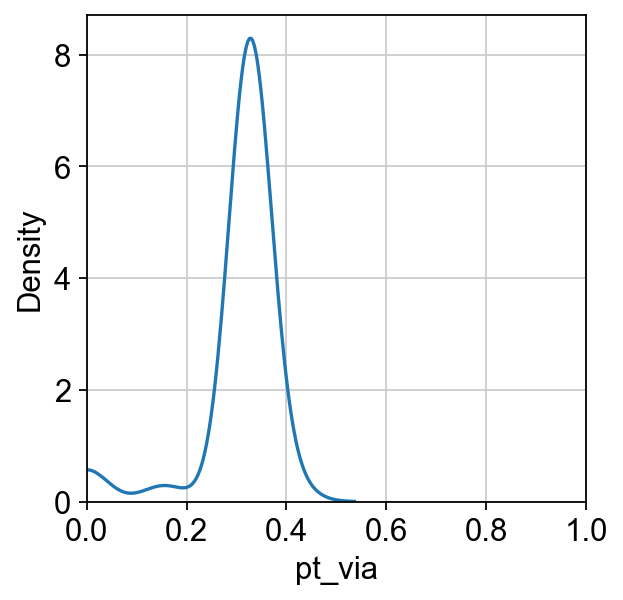

In [79]:
import seaborn as sns
sns.kdeplot(adata2.obs.loc[adata2.obs['celltype']=='Basophil'],x='pt_via')
plt.xlim(0,1)

In [81]:
np.var(adata2.obs.loc[adata2.obs['celltype']=='Basophil','pt_via'])

0.007093842603434545

In [82]:
res_dict={}

#Cor:exp
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)
# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

res_dict['Cor_mean']=diagonal_mean
res_dict['non_Cor_mean']=non_diagonal_mean

#Cos:gene
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

res_dict['Cos_mean']=diagonal_mean
res_dict['non_Cos_mean']=non_diagonal_mean

#raw:trans
res_dict['Trans_raw']=raw_transitions.loc['Basophil'].max()
res_dict['Trans_after']=after_transitions.loc['Basophil'].max()


#Variance
res_dict['Var_raw']=np.var(adata2.obs.loc[adata2.obs['celltype']=='Basophil','pt_via'])
res_dict['Var_after']=np.var(adata1.obs.loc[adata1.obs['celltype']=='Basophil','pt_via'])


In [83]:
res_dict

{'Cor_mean': 0.5631987742145932,
 'non_Cor_mean': -0.023593777334333103,
 'Cos_mean': 0.6440443313050281,
 'non_Cos_mean': 0.04967595132995179,
 'Trans_raw': 0.0,
 'Trans_after': 0.021442250696755896,
 'Var_raw': 0.007093842603434545,
 'Var_after': 0.012282284923191812}

In [84]:
import pickle
with open('result/metric_btb_hpc.pkl','wb') as f:
    pickle.dump(res_dict,f)

In [85]:
with open('result/metric_btb_hpc.pkl','rb') as f:
    res_dict=pickle.load(f)
res_dict

{'Cor_mean': 0.5631987742145932,
 'non_Cor_mean': -0.023593777334333103,
 'Cos_mean': 0.6440443313050281,
 'non_Cos_mean': 0.04967595132995179,
 'Trans_raw': 0.0,
 'Trans_after': 0.021442250696755896,
 'Var_raw': 0.007093842603434545,
 'Var_after': 0.012282284923191812}